# APIM ❤️ OpenAI

## Token Rate Limiting lab
![flow](../../images/token-rate-limiting.gif)

Playground to try the [token rate limiting policy](https://learn.microsoft.com/en-us/azure/api-management/azure-openai-token-limit-policy) to one or more Azure OpenAI endpoints.

The `azure-openai-token-limit` policy prevents Azure OpenAI Service API usage spikes on a per key basis by limiting consumption of language model tokens to a specified number per minute. When the token usage is exceeded, the caller receives a `429 Too Many Requests` response status code.

By relying on token usage metrics returned from the OpenAI endpoint, the policy can accurately monitor and enforce limits in real time. The policy also enables precalculation of prompt tokens by API Management, minimizing unnecessary requests to the OpenAI backend if the limit is already exceeded.

### Result
![result](images/result.png)

### TOC
- [0️⃣ Initialize notebook variables](#0)
- [1️⃣ Create the Azure Resource Group](#1)
- [2️⃣ Create deployment using 🦾 Bicep](#2)
- [3️⃣ Get the deployment outputs](#3)
- [🧪 Test the API using a direct HTTP call](#requests)
- [🔍 Analyze Token Rate limiting results](#plot)
- [🧪 Test the API using the Azure OpenAI Python SDK](#sdk)
- [🗑️ Clean up resources](#clean)

### Prerequisites
- [Python 3.8 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/en-us/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)

<a id='2'></a>
### 2️⃣ Create deployment using Terraform

This lab uses Terraform to declaratively define all the resources that will be deployed. Change the [variables.tf](variables.tf) directly to try different configurations.

In [ ]:
! terraform init
! terraform apply -auto-approve

⚠️ Make sure to use API Management SKU other than `Consumption` to use the policy `azure-openai-token-limit`.

<a id='3'></a>
### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [16]:
apim_resource_gateway_url = ! terraform output -raw apim_resource_gateway_url
apim_resource_gateway_url = apim_resource_gateway_url.n
print("👉🏻 APIM Resource Gateway URL: ", apim_resource_gateway_url)

apim_subscription_key = ! terraform output -raw apim_subscription_key
apim_subscription_key = apim_subscription_key.n
print("👉🏻 APIM Subscription Key : ", apim_subscription_key)

openai_api_version = "2024-10-21"
openai_model_name = "gpt-4o"
openai_deployment_name = "gpt-4o"

👉🏻 APIM Resource Gateway URL:  https://apim-genai-310-qa.azure-api.net
👉🏻 APIM Subscription Key :  c08fff7b98a04ddda0e669ce28edebba


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

In [18]:
import requests
import json

url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(10):
    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Oh sure, let me just pull out my magical time-telling abilities... Any second now... Oh wait, I can't actually tell you the time. You'll have to check a clock, your phone, or maybe the sundial in your garden.
▶️ Run:  2 status code:  200 ✅
💬  Oh, sure! Let me just check my invisible clock that's definitely not fictional. Done! It’s whenever you decide it should be. Time is just a construct anyway!
▶️ Run:  3 status code:  200 ✅
💬  Oh sure, let me just check my imaginary watch. Unfortunately, as a text-based AI, I live in a timeless void and can't check the current time. Maybe try looking at a clock or your phone? They're usually pretty good at that!
▶️ Run:  4 status code:  200 ✅
💬  Oh sure, let me just consult my magic crystal ball... oh wait, I must have left it in my other virtual pocket! Maybe try glancing at literally any device around you that tells time.
▶️ Run:  5 status code:  200 ✅
💬  Oh, absolutely! Let me just teleport to wherever you are—o

<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results


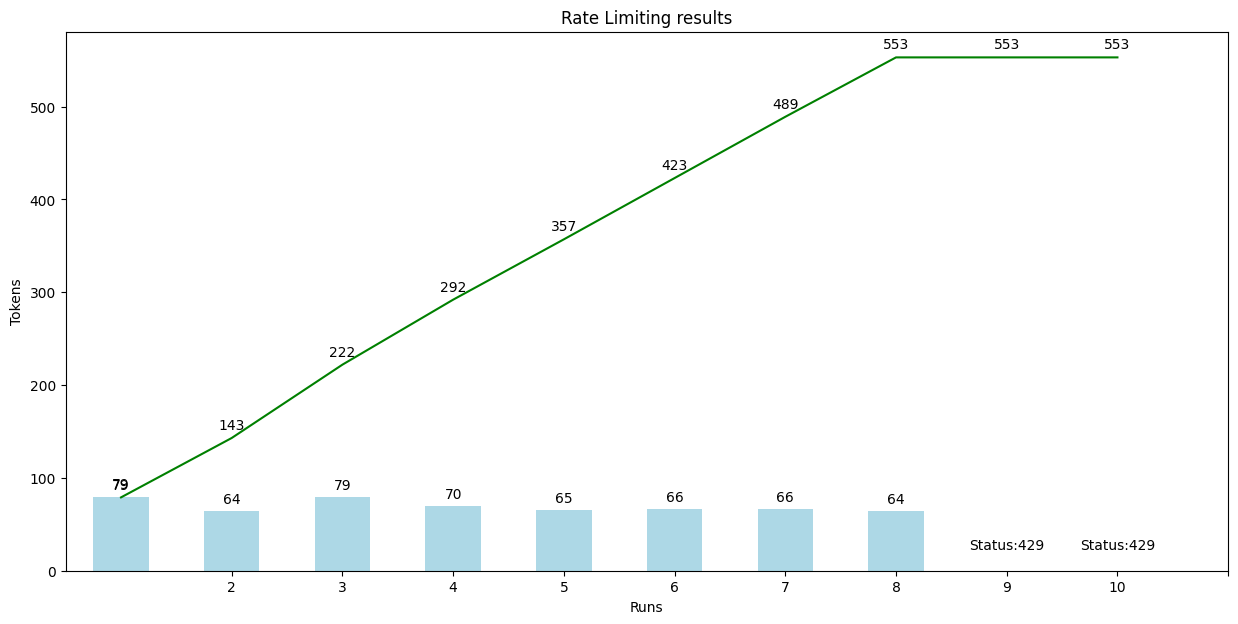

In [19]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else int(val), ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, int(val), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

We want confirm with this test that the SDK is performing retries automatically.

In [ ]:
import time
from openai import AzureOpenAI
for i in range(10):
    print("▶️ Run: ", i+1)
    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]
    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )
    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    print("💬 ",response.choices[0].message.content)


▶️ Run:  1
💬  Oh sure, let me just whip out my crystal ball and divine the time for you. Or, you know, you could just look at the clock on your device like a regular human in the 21st century.
▶️ Run:  2
💬  Oh sure, let me just consult my handy-dandy time-travel device. Oh wait, I don't have one! You might want to check a clock or your smartphone for that, they tend to be pretty good at telling time.
▶️ Run:  3
💬  Oh, sure! Let me just dust off my magic crystal ball... Oh wait, it seems to be out of batteries. Looks like you'll have to check a clock, phone, or any other magical time-keeping device you might have laying around.
▶️ Run:  4
💬  Sure, it's exactly the time you should already know because checking a clock is so 2023.
▶️ Run:  5
💬  Oh, absolutely! It's precisely time for you to look at a clock or a smartphone. They're really useful for this sort of thing.
▶️ Run:  6


<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.

In [ ]:
! terraform destroy -auto-approve